# Regression

## Importing libraries

In [143]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

## Preparing the dataset

In [144]:
random_state = 42
np.random.seed(random_state)

df = pd.read_csv('laptops.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df[['ram', 'storage', 'screen', 'final_price']]
df

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


## EDA

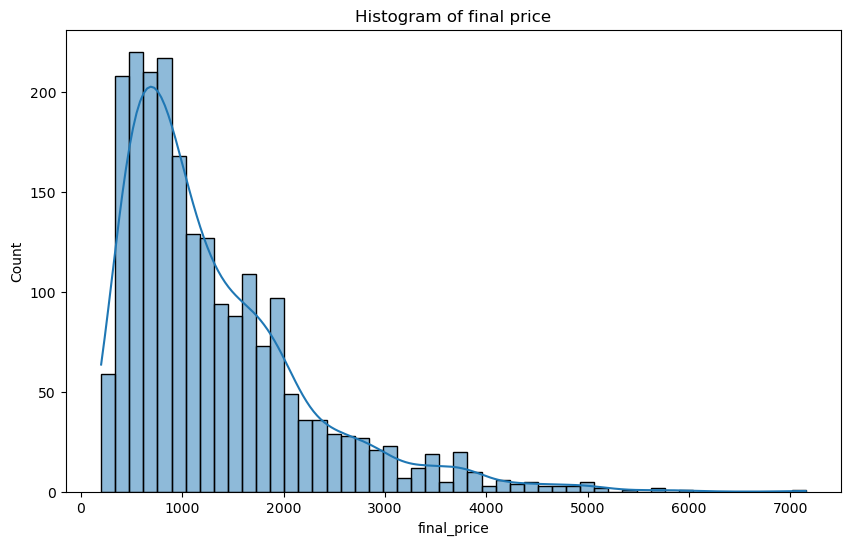

In [145]:
plt.figure(figsize=(10, 6))
sns.histplot(df['final_price'], bins=50, kde=True)
plt.title('Histogram of final price')
plt.show()

## Question 1

In [146]:
column = df.columns[df.isnull().any()].values[0]
f'Column with missing values is {column}'

'Column with missing values is screen'

## Question 2

In [147]:
median = round(df['ram'].median())
f"Median for variable 'ram' is {median}"

"Median for variable 'ram' is 16"

## Splitting the dataset

In [148]:
#train_data, temp_data = train_test_split(df, test_size=0.4, random_state=random_state)
# val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=random_state)

def split(df):
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    return df_train, df_val, df_test

In [149]:
df_train, df_val, df_test = split(df)

## Question 3

In [150]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    # normal equation
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]
                            

### Option 1: fill with zeros

In [151]:
def prepare_X_zeros(df):
    df_X = df.drop('final_price', axis=1)
    df_filled = df_X.fillna(0)
    return df_filled.values

In [152]:
X_train = prepare_X_zeros(df_train)
y_train = df_train.final_price
w_0, w = train_linear_regression(X_train, y_train)

In [153]:
y_pred = w_0 + X_train.dot(w)

In [154]:
X_val = prepare_X_zeros(df_val)
y_val = df_val.final_price
y_pred_val = w_0 + X_val.dot(w)

In [155]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [156]:
f'RMSE for train dataset. Option 1. {round(rmse(y_train, y_pred), 2)}'

'RMSE for train dataset. Option 1. 602.39'

In [157]:
f'RMSE for validation dataset. Option 1. {round(rmse(y_val, y_pred_val), 2)}'

'RMSE for validation dataset. Option 1. 597.36'

### Option 2: fill with train mean

In [158]:
def prepare_X_mean(df, mean = None):
    df_X = df.drop('final_price', axis=1)
    if mean is None: 
        mean = df_X.mean()
        df_filled = df_X.fillna(mean)
    else:
        df_filled = df_X.fillna(mean)
    return df_filled.values, mean

In [159]:
X_train, mean = prepare_X_mean(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [160]:
X_val, mean = prepare_X_mean(df_val, mean)
y_pred_val = w_0 + X_val.dot(w)

In [161]:
f'RMSE for validation dataset. Option 2. {rmse(y_val, y_pred_val)}'

'RMSE for validation dataset. Option 2. 600.2650313748422'

Fill with 0 gives better RMSE

## Question 4

In [162]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [163]:
X_train = prepare_X_zeros(df_train)
X_val = prepare_X_zeros(df_val)

In [164]:
rs = [0, 0.01, 0.1, 1, 5, 10, 100]
best_rmse = float('inf')
best_r = rs[0]
for r in rs:
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred_val = w_0 + X_val.dot(w)
    val_rmse = rmse(y_val, y_pred_val)
    print(f"r {r} gives {round(val_rmse, 3)} RMSE")
    if val_rmse < best_rmse:
        best_r = r
        best_rmse = val_rmse

r 0 gives 597.364 RMSE
r 0.01 gives 597.362 RMSE
r 0.1 gives 597.345 RMSE
r 1 gives 597.212 RMSE
r 5 gives 597.011 RMSE
r 10 gives 597.059 RMSE
r 100 gives 597.903 RMSE


In [165]:
f"r equal {best_r} gives the best RMSE"

'r equal 5 gives the best RMSE'

## Question 5

In [166]:
random_states = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for random_state in random_states:
    np.random.seed(random_state)
    df_train, df_val, df_test = split(df)
    X_train = prepare_X_zeros(df_train)
    y_train = df_train.final_price
    w_0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X_zeros(df_val)
    y_val = df_val.final_price
    y_pred_val = w_0 + X_val.dot(w)
    val_rmse = rmse(y_val, y_pred_val)
    print(f"Seed {random_state} gives {round(val_rmse, 3)} RMSE")
    scores.append(val_rmse)

f"Standard deviation of all the scores {round(np.std(scores), 3)}"

Seed 0 gives 565.452 RMSE
Seed 1 gives 636.799 RMSE
Seed 2 gives 588.956 RMSE
Seed 3 gives 597.815 RMSE
Seed 4 gives 571.963 RMSE
Seed 5 gives 573.238 RMSE
Seed 6 gives 647.344 RMSE
Seed 7 gives 550.44 RMSE
Seed 8 gives 587.334 RMSE
Seed 9 gives 576.102 RMSE


'Standard deviation of all the scores 29.176'

## Question 6

In [167]:
df_final = pd.concat([df_train, df_val])
X_train = prepare_X_zeros(df_final)
y_train = df_final.final_price
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
X_test = prepare_X_zeros(df_test)
y_test = df_test.final_price
y_pred_test = w_0 + X_test.dot(w)
test_rmse = rmse(y_test, y_pred_test)
f"{round(test_rmse, 2)} RMSE on the test dataset"

'608.61 RMSE on the test dataset'